In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Load credit approval dataset from UCI repository
df = pd.read_csv('https://archive.ics.uci.edu/static/public/27/data.csv')

# Inspect dataset
print(len(df))
print(df.head())
print(df.isna().sum())
print(df.dtypes)

690
  A1     A2     A3 A4 A5 A6 A7    A8 A9 A10  A11 A12 A13    A14  A15 A16
0  b  30.83  0.000  u  g  w  v  1.25  t   t    1   f   g  202.0    0   +
1  a  58.67  4.460  u  g  q  h  3.04  t   t    6   f   g   43.0  560   +
2  a  24.50  0.500  u  g  q  h  1.50  t   f    0   f   g  280.0  824   +
3  b  27.83  1.540  u  g  w  v  3.75  t   t    5   t   g  100.0    3   +
4  b  20.17  5.625  u  g  w  v  1.71  t   f    0   f   s  120.0    0   +
A1     12
A2     12
A3      0
A4      6
A5      6
A6      9
A7      9
A8      0
A9      0
A10     0
A11     0
A12     0
A13     0
A14    13
A15     0
A16     0
dtype: int64
A1      object
A2     float64
A3     float64
A4      object
A5      object
A6      object
A7      object
A8     float64
A9      object
A10     object
A11      int64
A12     object
A13     object
A14    float64
A15      int64
A16     object
dtype: object


In [24]:
# Check for patterns in missing data
print(df[df['A1'].isna()])
print(df[df['A2'].isna()])
print(df[df['A14'].isna()])

      A1     A2      A3 A4 A5   A6   A7     A8 A9 A10  A11 A12 A13     A14  \
248  NaN  24.50  12.750  u  g    c   bb  4.750  t   t    2   f   g    73.0   
327  NaN  40.83   3.500  u  g    i   bb  0.500  f   f    0   f   s  1160.0   
346  NaN  32.25   1.500  u  g    c    v  0.250  f   f    0   t   g   372.0   
374  NaN  28.17   0.585  u  g   aa    v  0.040  f   f    0   f   g   260.0   
453  NaN  29.75   0.665  u  g    w    v  0.250  f   f    0   t   g   300.0   
479  NaN  26.50   2.710  y  p  NaN  NaN  0.085  f   f    0   f   s    80.0   
489  NaN  45.33   1.000  u  g    q    v  0.125  f   f    0   t   g   263.0   
520  NaN  20.42   7.500  u  g    k    v  1.500  t   t    1   f   g   160.0   
598  NaN  20.08   0.125  u  g    q    v  1.000  f   t    1   f   g   240.0   
601  NaN  42.25   1.750  y  p  NaN  NaN  0.000  f   f    0   t   g   150.0   
641  NaN  33.17   2.250  y  p   cc    v  3.500  f   f    0   t   g   200.0   
673  NaN  29.50   2.000  y  p    e    h  2.000  f   f    0   f  

In [ ]:
# Transform target variable to numeric and drop rows with missing values
df['A16'] = df['A16'].map({'+': 1, '-': 0})
df.dropna(how='any', inplace=True)

# Check class distribution
print(df['A16'].value_counts(normalize=True))

A16
0    0.546708
1    0.453292
Name: proportion, dtype: float64


In [26]:
# Split features and target variable
X = df.loc[:, df.columns != 'A16'].values
y = df['A16'].values

In [28]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Identify categorical columns
df_cat = df.loc[:, df.dtypes == 'object']
print(df_cat.nunique())

# Identify columns for different encoding strategies depending on cardinality
ohe_cols = list(df_cat.columns[df_cat.nunique() <= 6])
ore_cols = list(df_cat.columns[df_cat.nunique() > 6])
pt_cols = list(df.loc[:, df.dtypes != 'object'].columns)

# Use ColumnTransformer to apply different encodings 
# (one-hot for low cardinality, ordinal for high cardinality, passthrough for numeric)
ohe = OneHotEncoder(drop='first')
ore = OrdinalEncoder()

c_transf = ColumnTransformer([
    ('oh', ohe, ohe_cols),
    ('or', ore, ore_cols),
    ('n', 'passthrough', pt_cols)
])

# Transform categorical variables 
values_transf = c_transf.fit_transform(df)
feat_labels = c_transf.get_feature_names_out()
print(values_transf)
print(values_transf.shape)


A1      2
A4      3
A5      3
A6     14
A7      9
A9      2
A10     2
A12     2
A13     3
dtype: int64
[[  1.   1.   0. ... 202.   0.   1.]
 [  0.   1.   0. ...  43. 560.   1.]
 [  0.   1.   0. ... 280. 824.   1.]
 ...
 [  0.   0.   1. ... 200.   1.   0.]
 [  1.   1.   0. ... 280. 750.   0.]
 [  1.   1.   0. ...   0.   0.   0.]]
(653, 19)


In [29]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X, y = values_transf[:, 0:-1], values_transf[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(457, 18) (457,)
(196, 18) (196,)


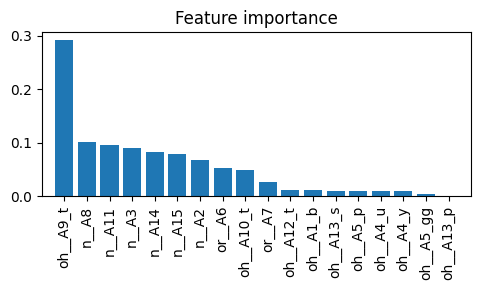

In [30]:
from sklearn.ensemble import RandomForestClassifier

# View feature importance using Random Forest
forest = RandomForestClassifier(n_estimators=500, random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(5, 3))
plt.title('Feature importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')
plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

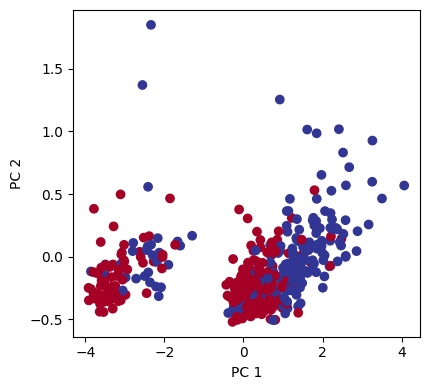

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Visualize data using PCA
pipe_pca = make_pipeline(
    StandardScaler(),
    PCA(n_components=2)
)

X_train_pca = pipe_pca.fit_transform(X_train)

keep_indices = np.where(X_train_pca[:, 1] <= 4)[0]

plt.figure(figsize=(4.4, 4))
plt.scatter(X_train_pca[keep_indices, 0], 
            X_train_pca[keep_indices, 1], 
            c=y_train[keep_indices],
            cmap='RdYlBu')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.tight_layout()
plt.show()

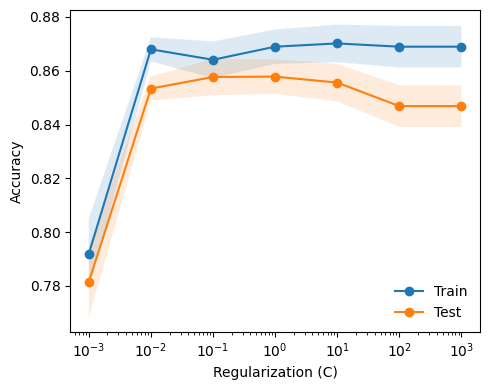

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve

# Validation curve for Logistic Regression regularization parameter C
pipe_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

param_range = 10.**np.arange(-3, 4)
train_scores, test_scores = validation_curve(
                            estimator=pipe_lr,
                            X=X_train,
                            y=y_train,
                            param_name='logisticregression__C',
                            param_range=param_range,
                            cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(train_scores, axis=1)

plt.figure(figsize=(5, 4))
plt.plot(param_range, train_mean, marker='o', label='Train')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15)
plt.plot(param_range, test_mean, marker='o', label='Test')
plt.fill_between(param_range, test_mean + test_std,
                 test_mean - test_std, alpha=0.15)
plt.xscale('log')
plt.legend(loc='lower right', frameon=False)
plt.xlabel('Regularization (C)')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Hyperparameter tuning for Logistic Regression using RandomizedSearchCV 
pipe_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

param_range = loguniform(0.001, 1000)
param_grid = [{'logisticregression__C': param_range,
               'logisticregression__penalty': ['l1', 'l2'],
               'logisticregression__solver': ['liblinear']}]

rs = RandomizedSearchCV(estimator=pipe_lr,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=50,
                        cv=10,
                        random_state=1)

rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

best_lr = rs.best_estimator_
best_lr.fit(X_train, y_train)
print(f'Train accuracy: {best_lr.score(X_train, y_train):.3f}')
print(f'Test accuracy: {best_lr.score(X_test, y_test):.3f}')

0.8600000000000001
{'logisticregression__C': 1.4086278196393132, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Train accuracy: 0.869
Test accuracy: 0.898


In [ ]:
from sklearn.svm import SVC

# Hyperparameter tuning for SVM using RandomizedSearchCV
pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(probability=True)
)

param_range = loguniform(0.001, 1000)
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
               {'svc__C': param_range,
                'svc__gamma': param_range,
                'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1)

rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

best_svc = rs.best_estimator_
best_svc.fit(X_train, y_train)
print(f'Train accuracy: {best_svc.score(X_train, y_train):.3f}')
print(f'Test accuracy: {best_svc.score(X_test, y_test):.3f}')

0.8533816425120773
{'svc__C': 0.23959864837279687, 'svc__kernel': 'linear'}
Train accuracy: 0.858
Test accuracy: 0.888


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Classification using Random Forest
forest = RandomForestClassifier(n_estimators=100, 
                                criterion='entropy',
                                random_state=1)

forest.fit(X_train, y_train)

print(f'Train accuracy: {forest.score(X_train, y_train):.3f}')
print(f'Test accuracy: {forest.score(X_test, y_test):.3f}')

conf_mat = confusion_matrix(y_true=y_test, y_pred=forest.predict(X_test))
print('Confusion matrix:')
print(conf_mat)

Train accuracy: 1.000
Test accuracy: 0.923
Confusion matrix:
[[103   6]
 [  9  78]]


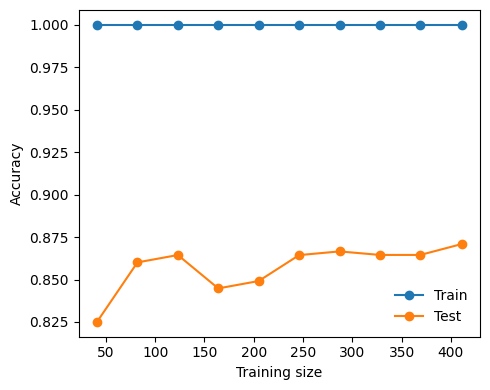

In [37]:
from sklearn.model_selection import learning_curve

# Learning curve for Random Forest
forest = RandomForestClassifier(n_estimators=100, 
                                criterion='entropy',
                                random_state=1)

train_sizes, train_scores, test_scores = learning_curve(estimator=forest,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(train_scores, axis=1)

plt.figure(figsize=(5, 4))
plt.plot(train_sizes, train_mean, marker='o', label='Train')
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std, alpha=0.15)
plt.plot(train_sizes, test_mean, marker='o', label='Test')
plt.fill_between(train_sizes, test_mean + test_std,
                 test_mean - test_std, alpha=0.15)
plt.legend(loc='lower right', frameon=False)
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

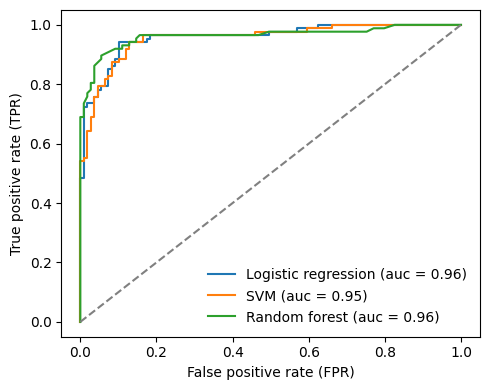

In [38]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# ROC curves for Logistic Regression, SVM, and Random Forest classifiers
clfs = [pipe_lr, pipe_svc, forest]
clfs_labels = ['Logistic regression', 'SVM', 'Random forest']

plt.figure(figsize=(5, 4))

for clf, label in zip(clfs, clfs_labels):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr,
             label=f'{label} (auc = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.legend(loc='lower right', frameon=False)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.tight_layout()
plt.show()


In [44]:
from xgboost import XGBClassifier
from scipy.stats import randint

# Hyperparameter tuning for XGBoost using RandomizedSearchCV
xgb = XGBClassifier(random_state=1)

param_grid = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 6),
    'learning_rate': loguniform(0.01, 0.3)
}

rs = RandomizedSearchCV(estimator=xgb,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1)


rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

best_xgb = rs.best_estimator_
best_xgb.fit(X_train, y_train)
print(f'Train accuracy: {best_xgb.score(X_train, y_train):.3f}')
print(f'Test accuracy: {best_xgb.score(X_test, y_test):.3f}')

0.8557004830917874
{'learning_rate': 0.1709398504585972, 'max_depth': 4, 'n_estimators': 471}
Train accuracy: 1.000
Test accuracy: 0.913


In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Compare classification performance of different models
models = {
    'Logistic Regression': best_lr,
    'SVM': best_svc,
    'Random Forest': forest,
    'XGBoost': best_xgb
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    })

# Create table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print(results_df)

                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
2        Random Forest  0.923469   0.928571  0.896552  0.912281  0.962881
3              XGBoost  0.913265   0.906977  0.896552  0.901734  0.950438
0  Logistic Regression  0.897959   0.845361  0.942529  0.891304  0.958347
1                  SVM  0.887755   0.815534  0.965517  0.884211  0.936202
